<img src='img/logo.png'>

# Data Science Use Case: Literacy and Fertility

Packages we'll use
-----------------

*There are alternative packages and techniques you might use*

<div class="row">
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='http://docs.python-requests.org/en/master/'>
        <img src='http://docs.python-requests.org/en/master/_static/requests-sidebar.png' style='height:80px'>
         <div class='caption'>HTTP-based web interactions</div>
     </a>
   </div>
 </div>
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='https://www.crummy.com/software/BeautifulSoup/bs4/doc/'>
       <img src='https://singbookswithemily.files.wordpress.com/2015/03/beautiful-soup-can-w-mock-turtle-coin.jpg' style='height:80px'> 
        <div class='caption'>Parse HTML documents</div>
     </a>
   </div>
 </div>
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='https://sqlalchemy.org'>
       <img src='http://www.alessandrocucci.it/pyre/restapi/assets/sqlalchemy.png' style='height:80px'> 
        <div class='caption'>Database access</div>
     </a>
   </div>
 </div>
</div>    
<div class="row">
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='https://numpy.org'>
       <img src='https://cdn-images-1.medium.com/max/400/1*mc5YIn7jvo5uwuqBOUDw7Q.jpeg' style='height:80px'> 
        <div class='caption'>Array-based computation</div>
     </a>
   </div>
 </div>
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='https://pandas.pydata.org'>
       <img src='https://pandas.pydata.org/_static/pandas_logo.png' style='height:80px' > 
        <div class='caption'>Tabular Data</div>
     </a>
   </div>
 </div>
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='https://matplotlib.org'>
       <img src='https://matplotlib.org/_static/logo2.png' style='height:80px' > 
        <div class='caption'>Plotting and visualization</div>
     </a>
   </div>
 </div>
</div>    
<div class="row">
 <div class="col-md-4">
   <div class="thumbnail">
     <a href='https://scikit-learn.org'>
       <img src='http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png' style='height:80px' > 
        <div class='caption'>Machine Learning and Modeling</div>
     </a>
   </div>
 </div>
</div>    

Import code to use later
------------------------

In [1]:
# Get data from internet
import requests

# Read HTML
from bs4 import BeautifulSoup

# Database connection
from sqlalchemy import create_engine

# Data Processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

Read data
--------

[Female Literacy Rates from Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_literacy_rate)

In [26]:
# Get raw html
wikipedia = 'https://en.wikipedia.org/w/index.php'
html = requests.get(wikipedia, params=dict(title='List_of_countries_by_literacy_rate',oldid=809221941)).content

In [2]:
# Process HTML to list-of-dictionaries

soup = BeautifulSoup(html, 'lxml')
rows = soup.find('table', attrs={'class':'sortable wikitable'}).find_all('tr')[3:]

literacy = []
for row in rows:
    columns = row.find_all('td')
    
    name = columns[0].text.strip()
    try:
        overall = float(columns[1].text[:6])
        male = float(columns[2].text[:-1])
        female = float(columns[3].text[:-1])
    except:
        value = None
    
    literacy.append({'Country':name, 'overall literacy':overall, 
                     'male literacy':male, 'female literacy':female})

## Data Frames: tabular data manipulation

In [25]:
literacy = pd.DataFrame.from_records(literacy)
literacy.head()

,Country,female literacy,male literacy,overall literacy
0,Afghanistan,24.2,52.0,38.156
1,Albania,96.8,98.4,97.553
2,Algeria,73.1,87.2,80.198
3,Andorra,73.1,87.2,80.198
4,Angola,60.7,82.0,71.140


Top countries where *female literacy* is larger than *male literacy*.

In [19]:
high_female = literacy.loc[literacy['female literacy'] > literacy['male literacy']]
high_female.nlargest(5, 'female literacy')

,Country,female literacy,male literacy,overall literacy
43,Cuba,99.8,99.7,99.711
131,Palau,99.6,99.5,99.523
174,Tonga,99.4,99.3,99.397
146,Samoa,99.1,98.9,99.015
147,San Marino,99.1,98.9,99.015


## One More Data Source: SQL table

Other Economic and social indicators from [Gapminder.org](gapminder.org)

In [15]:
database = create_engine('sqlite:///data/gapminder.sqlite')
fertility = pd.read_sql('select Country,fertility,Year from world_data', 
                        database)

fertility_2013 = fertility.loc[fertility['Year']==2013, 
                               ['Country','fertility']]
fertility_2013.head()

,Country,fertility
49,Afghanistan,4.900
99,Albania,1.771
149,Algeria,2.795
199,Angola,5.863
249,Antigua and Barbuda,2.089


Merge and Process data
--------------------

In [6]:
merged_data = pd.merge(literacy, fertility_2013, 
                       on='Country', how='inner').dropna()
merged_data.head()

,Country,female literacy,male literacy,overall literacy,fertility
0,Afghanistan,24.2,52.0,38.156,4.900
1,Albania,96.8,98.4,97.553,1.771
2,Algeria,73.1,87.2,80.198,2.795
3,Angola,60.7,82.0,71.140,5.863
4,Antigua and Barbuda,60.7,82.0,71.140,2.089


In [8]:
merged_data.corr(method='pearson')

,female literacy,male literacy,overall literacy,fertility
female literacy,1.000000,0.957122,0.992806,-0.646406
male literacy,0.957122,1.000000,0.984785,-0.627928
overall literacy,0.992806,0.984785,1.000000,-0.645064
fertility,-0.646406,-0.627928,-0.645064,1.000000


Modeling
-------

In [20]:
X = merged_data[['female literacy']]
y = merged_data['fertility']

model = LinearRegression()
model.fit(X, y)

r_squared = model.score(X, y)
Fvalue, pvalue = f_regression(X, y)

In [21]:
print('Slope    {:7.3f}'.format(model.coef_[0]))
print('Inercept {:7.3f}'.format(model.intercept_))
print('R^2      {:7.3f}'.format(r_squared))
print('p-value  {:11.3e}'.format(pvalue[0]))

Slope     -0.042
Inercept   6.201
R^2        0.418
p-value    3.930e-21


Plotting
--------

We'll construct a simpler model with with just one Y column.

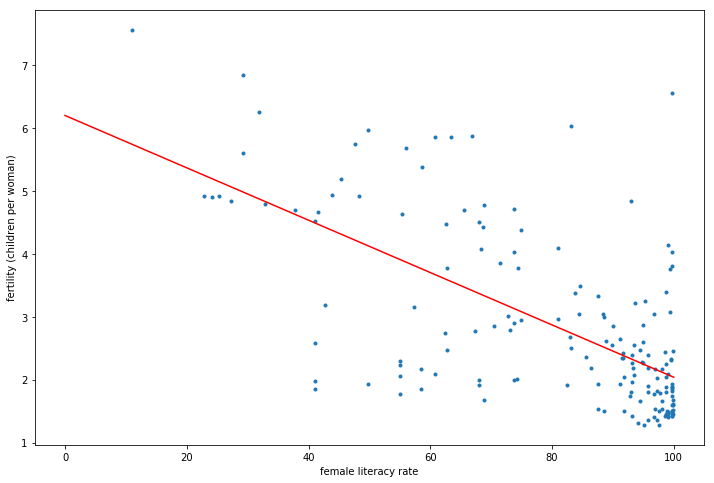

In [27]:
x_plot = np.linspace(0, 100, 2).reshape((2,1))
y_predicted = model.predict(x_plot)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X['female literacy'], y, marker='.')
ax.plot(x_plot, y_predicted, 'r')
ax.set_xlabel('female literacy rate')
ax.set_ylabel('fertility (children per woman)');

<img src='img/copyright.png'>